In [ ]:
'yt32eoi'

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
import pandas as pd
from datasets import load_dataset
from collections import Counter

In [2]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

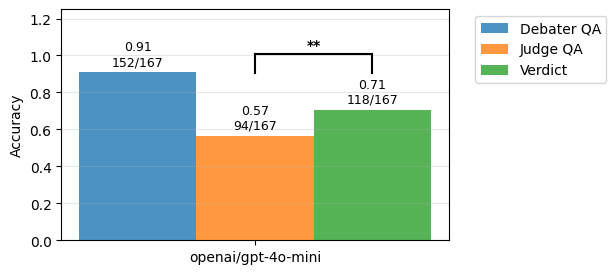

In [8]:

single_verdict =  ['k26y5y6'] # grok-4-fast as debater (4 choice)
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(single_verdict)]
# 
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

acc_gpqa = aggregate_by_fields(verdicts_df, ['config_judge_model_verdicts'])


ax, plt = plot_accuracy_bars_single(acc_gpqa, show_sig=True)

In [21]:
verdicts_df[['is_correct_qa_debater', 'is_correct_qa_judge', 'is_correct_verdict']].value_counts().reset_index()


,is_correct_qa_debater,is_correct_qa_judge,is_correct_verdict,count
0,True,True,True,69
1,True,False,True,41
2,True,False,False,23
3,True,True,False,18
4,False,False,False,5
5,False,True,True,4
6,False,False,True,3
7,False,True,False,3


In [23]:
# tft are the main successes and ttf are the main failures
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [32]:
tft['record_id_verdicts'].tolist()[:2]

['ky8qkpj', 'f1jkw43']

In [33]:
ttf['record_id_verdicts'].tolist()[:2]

['uwndxoj', '8uee8as']